In [56]:
import os
os.environ["DEVELOPMENT"] = "DEVELOPMENT"

In [57]:
from pathlib import Path
import json

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [58]:
results_dir = Path("results/complexify/fieldmngt")
config = json.load(open(results_dir / "config.json"))
gens = config["evolution_params"]["n_generations"]
tasks = config["evaluation_params"]["tasks"]
print(gens, tasks)
gens = 30

50 ['yield', 'irr', 'mulch']


In [59]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,rank,distance,yield,irr,mulch
0,41_52,"['37_26', '37_26']",1,inf,12.948883,-417.954545,-90.462190
1,48_38,"['45_59', '47_38']",1,inf,12.239127,-327.272727,-80.538016
2,49_8,"['33_27', '48_3']",1,inf,14.275352,-605.454545,-4.352001
3,43_40,"['40_79', '42_37']",1,inf,14.018541,-655.227273,0.000000
4,49_30,"['37_3', '37_3']",1,inf,11.852503,-391.363636,0.000000
...,...,...,...,...,...,...,...
95,50_29,"['49_54', '48_61']",1,0.011624,11.852590,-370.909091,-0.025733
96,50_0,"['49_67', '49_54']",1,0.010870,12.298775,-377.727273,-54.887524
97,50_12,"['49_28', '49_28']",1,0.009777,12.138425,-415.227273,-27.417203
98,50_13,"['49_30', '49_30']",1,0.006720,11.857185,-392.727273,0.000000


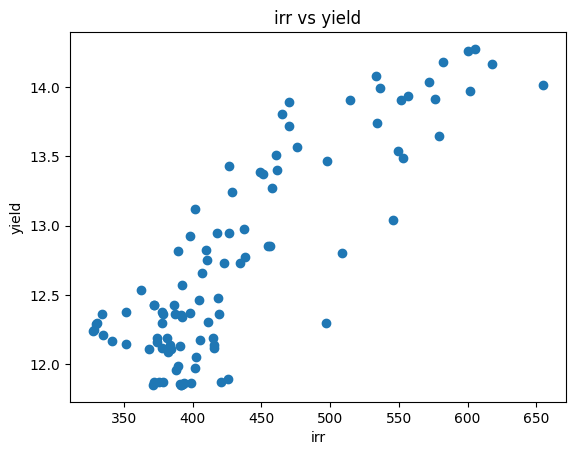

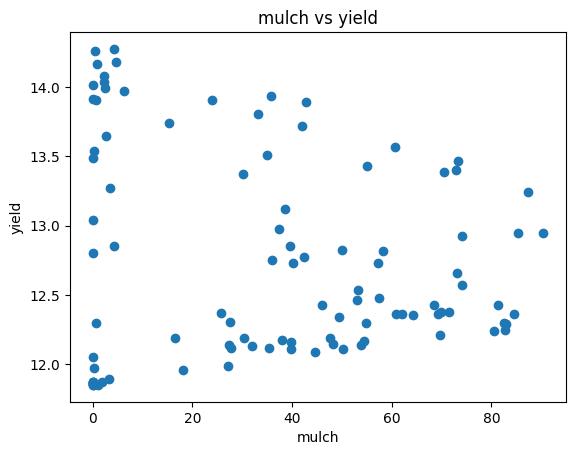

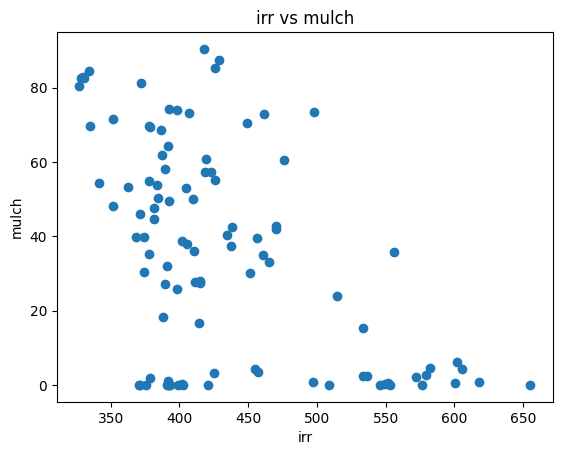

In [60]:
def plot_two_objective(task1, task2):
    result1 = final_pareto[task1] if task1 == "yield" else final_pareto[task1] * -1
    result2 = final_pareto[task2] if task2 == "yield" else final_pareto[task2] * -1
    plt.scatter(result1, result2)
    plt.title(f"{task1} vs {task2}")
    plt.ylabel(task2)
    plt.xlabel(task1)
    plt.show()

plot_two_objective("irr", "yield")
plot_two_objective("mulch", "yield")
plot_two_objective("irr", "mulch")

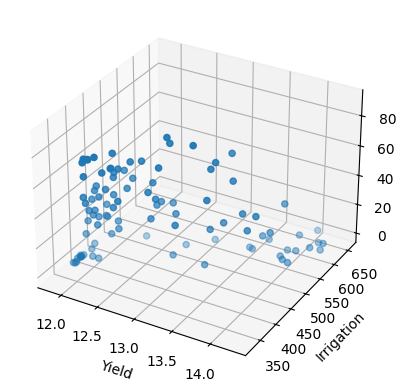

In [61]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(final_pareto["yield"], -1 * final_pareto["irr"], -1 * final_pareto["mulch"])
ax.set_xlabel("Yield")
ax.set_ylabel("Irrigation")
ax.set_zlabel("Mulch")
plt.show()

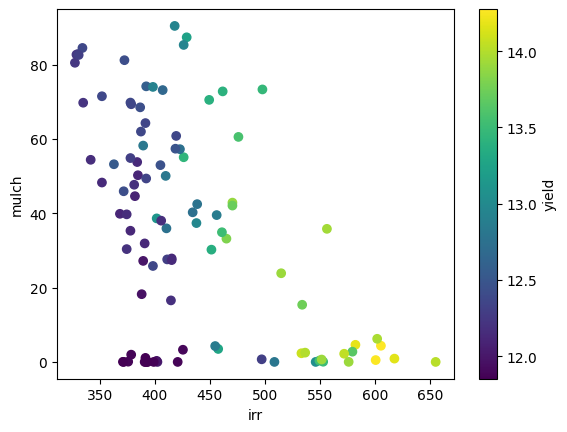

In [63]:
scatter = plt.scatter(-1 * final_pareto["irr"], -1 * final_pareto["mulch"], c=final_pareto["yield"])
plt.xlabel("irr")
plt.ylabel("mulch")
plt.colorbar(scatter).set_label("yield")
plt.show()

In [6]:
import numpy as np
from evolution.evaluation.evaluator import Evaluator
import warnings
from scipy.optimize import fmin

INFO:root:Running the simulation in development mode.
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/964840/anaconda3/envs/aquacrop/include -arch arm64 -fPIC -O2 -isystem /Users/964840/anaconda3/envs/aquacrop/include -arch arm64 -c /var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/tmpiwyxoa7y/temp.c -o /var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/tmpiwyxoa7y/temp.o
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/964840/anaconda3/envs/aquacrop/include -arch arm64 -fPIC -O2 -isystem /Users/964840/anaconda3/envs/aquacrop/include -arch arm64 -c /var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/tmplzfok20l/temp.cxx -o /var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/tmplzfok20l/temp.o


In [7]:
def evaluate(x, max_irr_season, evaluator, weather_df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        results = evaluator.run_model(weather_df, x, max_irr_season)
    reward = -1 * results["Dry yield (tonne/ha)"].mean()
    return reward

In [8]:
def get_starting_point(num_smts, max_irr_season, num_searches, evaluator, weather_df):
    """
    find good starting threshold(s) for optimization
    """

    # get random SMT's
    x0list = np.random.rand(num_searches,num_smts)*100
    rlist=[]
    # evaluate random SMT's
    for xtest in x0list:
        reward = evaluate(xtest, max_irr_season, evaluator, weather_df)
        rlist.append(reward)

    # save best SMT
    x0=x0list[np.argmin(rlist)]
    
    return x0

evaluator = Evaluator()

In [9]:
def optimize(num_smts, max_irr_season, evaluator, num_searches, weather_df):
    """ 
    optimize thresholds to be profit maximising
    """
    # get starting optimization strategy
    x0=get_starting_point(num_smts, max_irr_season, num_searches, evaluator, weather_df)
    # run optimization 
    res = fmin(evaluate, x0, disp=0, args=(max_irr_season, evaluator, weather_df))
    # reshape array
    smts= res.squeeze()
    # evaluate optimal strategy
    return smts

100%|██████████| 11/11 [00:47<00:00,  4.29s/it]


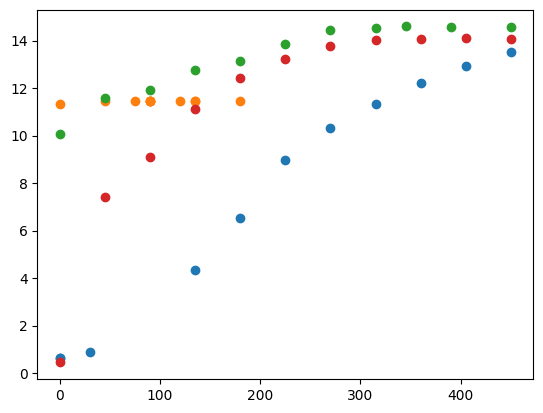

In [11]:
cities = ["tunis_climate", "brussels_climate", "hyderabad_climate", "champion_climate"]
weather_dfs, _ = evaluator.load_data(cities)
all_yields = []
all_irrs = []
for weather_df, city in zip(weather_dfs, cities):
    yields = []
    irrs = []
    points = 10
    for i in tqdm(range(points+1)):
        max_irr_season = i * (450/points)
        smts = optimize(4, max_irr_season, evaluator, 10, weather_df)
        results = evaluator.run_model(weather_df, smts, max_irr_season)
        dry_yield = results["Dry yield (tonne/ha)"].mean()
        irr = results["Seasonal irrigation (mm)"].mean()
        yields.append(dry_yield)
        irrs.append(irr)
    plt.scatter(irrs, yields, label=city)
    all_yields.append(yields)
    all_irrs.append(irrs)

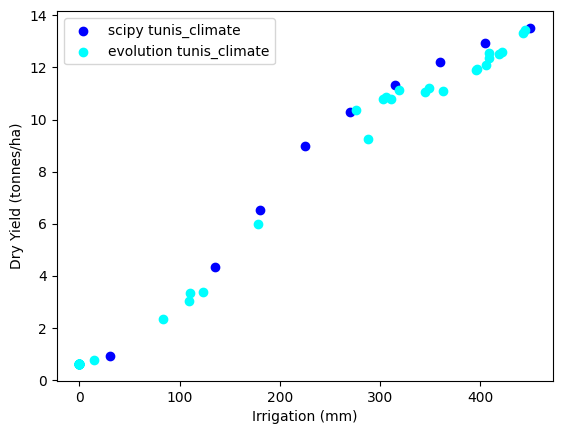

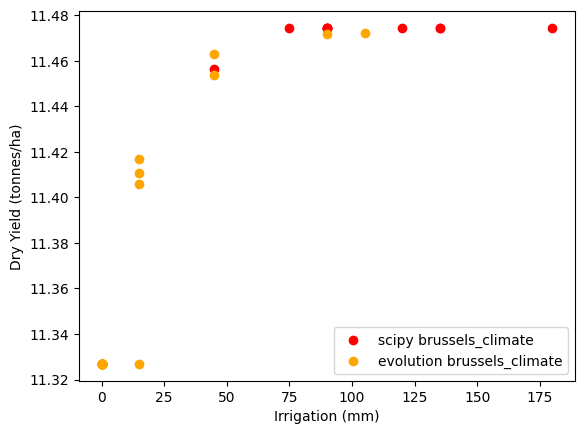

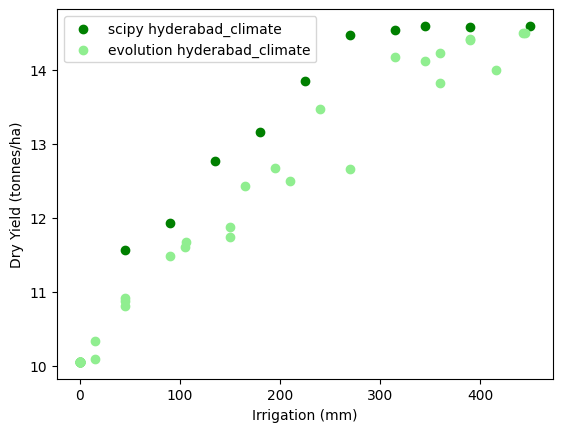

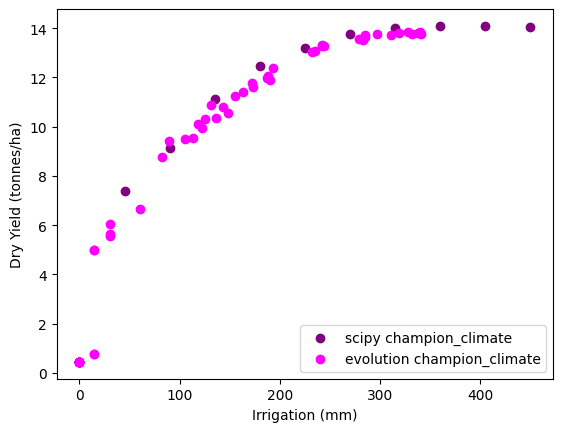

In [27]:
scipy_colors = ["blue", "red", "green", "purple"]
evo_colors = ["cyan", "orange", "lightgreen", "magenta"]
for i in range(len(cities)):
    plt.scatter(all_irrs[i], all_yields[i], label=f"scipy {cities[i]}", color=scipy_colors[i])
    plt.scatter(final_pareto[f"irr_{i}"], final_pareto[f"yield_{i}"], label=f"evolution {cities[i]}", color=evo_colors[i])
    plt.legend()
    plt.xlabel("Irrigation (mm)")
    plt.ylabel("Dry Yield (tonnes/ha)")
    plt.show()
# plt.show()

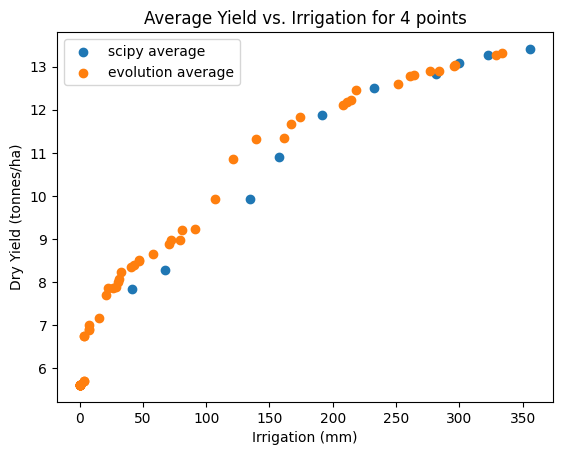

In [26]:
scipy_average_yields = np.mean(np.array(all_yields), axis=0)
scipy_average_irrs = np.mean(np.array(all_irrs), axis=0)
plt.scatter(scipy_average_irrs, scipy_average_yields, label="scipy average")
plt.scatter(-1 * final_pareto["irrigation"], final_pareto["yield"], label="evolution average")
plt.legend()
plt.title("Average Yield vs. Irrigation for 4 points")
plt.xlabel("Irrigation (mm)")
plt.ylabel("Dry Yield (tonnes/ha)")
plt.show()

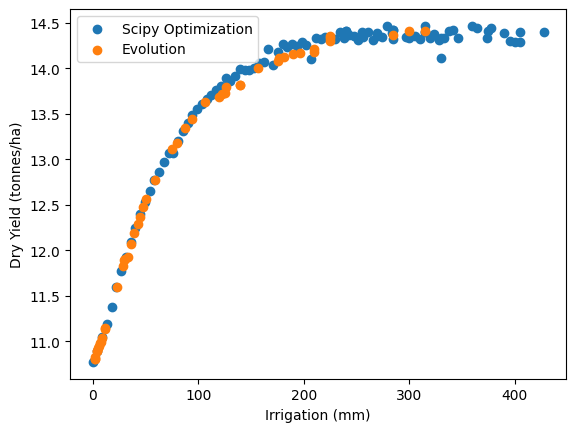

In [ ]:
plt.scatter(irrs, yields, label="Scipy Optimization")
plt.scatter(-1 * final_pareto["irrigation"], final_pareto["yield"], label="Evolution")
plt.legend()
plt.xlabel("Irrigation (mm)")
plt.ylabel("Dry Yield (tonnes/ha)")
plt.show()